In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Found 1653 images belonging to 2 classes.
Found 188 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 492s 8s/step - accuracy: 0.7003 - loss: 0.6994
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 465ms/step - accuracy: 0.8925 - loss: 0.2362
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 463ms/step - accuracy: 0.9283 - loss: 0.1909
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 159us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 461ms/step - accuracy: 0.9514 - loss: 0.1310
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 481ms/step - accuracy: 0.9503 - loss: 0.1251
Epoch 10/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


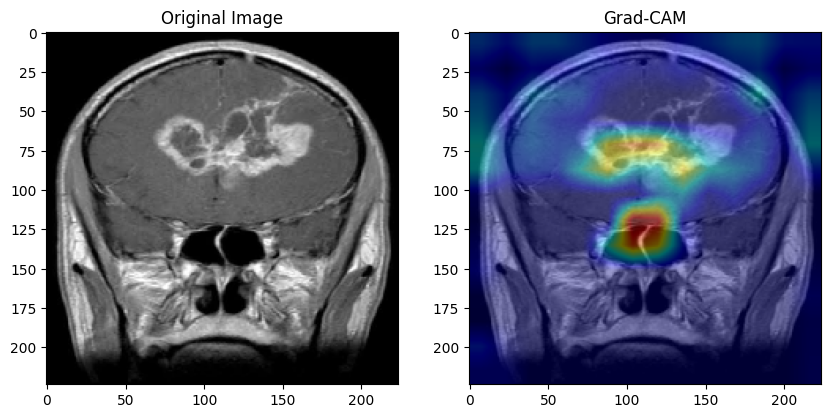

In [ ]:
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.efficientnet import EfficientNetB6, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Load pre-trained VGG16 model + higher level layers
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers (we don't want to train these layers)
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dense(2, activation="softmax")(x)  # Assuming 5 classes for your task

# Create the full model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

# Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Path to your train and test directories
train_dir = '/content/drive/MyDrive/datasets/train'
test_dir = '/content/drive/MyDrive/datasets/test'

# Loading the train and test data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical'
)

# Train the model on the training data
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10
)

# Grad-CAM function as defined earlier
def get_gradcam(model, img_array, class_idx, layer_name="block5_conv3"):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)

    # Compute the guided gradients
    guided_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the output feature map with the guided gradients
    conv_outputs = conv_outputs[0]
    weighted_sum = np.dot(conv_outputs, guided_grads)

    # Apply ReLU to the result to create the heatmap
    cam = np.maximum(weighted_sum, 0)

    # Normalize the heatmap
    cam = cam / cam.max() if cam.max() > 0 else cam
    return cam

# Preprocess the input image for VGG16
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array, img

# Post-process and visualize the Grad-CAM heatmap
def visualize_gradcam(image_path, cam, original_img):
    cam = cv2.resize(cam, (original_img.width, original_img.height))
    cam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)

    overlay = (0.4 * cam + np.array(original_img) * 0.6).astype(np.uint8)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM")
    plt.show()

# Test the model on a single image
test_img_path = '/content/drive/MyDrive/datasets/test/glioma_tumor/glioma_tumor_210 (1).jpg'
img_array, original_img = preprocess_image(test_img_path)

# Predict class of the test image
predictions = model.predict(img_array)
class_idx = np.argmax(predictions[0])

# Get the Grad-CAM heatmap
cam = get_gradcam(model, img_array, class_idx)

# Visualize the Grad-CAM result
visualize_gradcam(test_img_path, cam, original_img)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Found 1653 images belonging to 2 classes.
Found 188 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 605s 10s/step - accuracy: 0.6870 - loss: 0.8518
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


52/52 ━━━━━━━━━━━━━━━━━━━━ 48s 511ms/step - accuracy: 0.9173 - loss: 0.2086
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 130us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 498ms/step - accuracy: 0.9251 - loss: 0.1937
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 489ms/step - accuracy: 0.9491 - loss: 0.1371
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 513ms/step - accuracy: 0.9631 - loss: 0.1196
Epoch 10/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


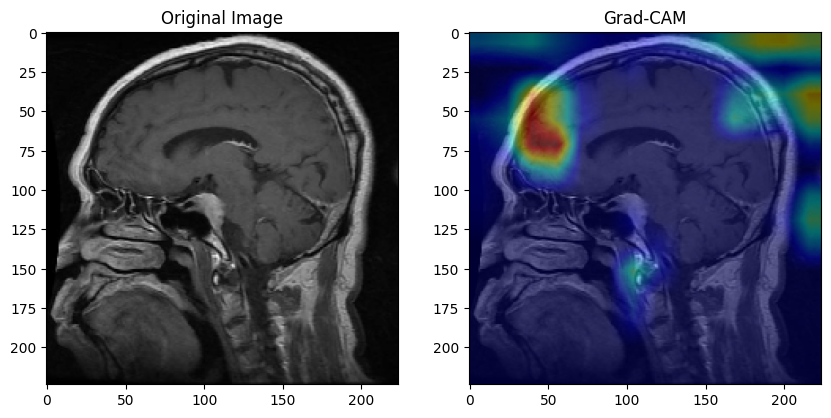

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Load pre-trained VGG16 model + higher level layers
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers (we don't want to train these layers)
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dense(2, activation="softmax")(x)  # Assuming 5 classes for your task

# Create the full model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

# Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Path to your train and test directories
train_dir = '/content/drive/MyDrive/datasets/train'
test_dir = '/content/drive/MyDrive/datasets/test'

# Loading the train and test data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical'
)

# Train the model on the training data
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10
)

# Grad-CAM function as defined earlier
def get_gradcam(model, img_array, class_idx, layer_name="block5_conv3"):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)

    # Compute the guided gradients
    guided_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the output feature map with the guided gradients
    conv_outputs = conv_outputs[0]
    weighted_sum = np.dot(conv_outputs, guided_grads)

    # Apply ReLU to the result to create the heatmap
    cam = np.maximum(weighted_sum, 0)

    # Normalize the heatmap
    cam = cam / cam.max() if cam.max() > 0 else cam
    return cam

# Preprocess the input image for VGG16
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array, img

# Post-process and visualize the Grad-CAM heatmap
def visualize_gradcam(image_path, cam, original_img):
    cam = cv2.resize(cam, (original_img.width, original_img.height))
    cam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)

    overlay = (0.4 * cam + np.array(original_img) * 0.6).astype(np.uint8)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM")
    plt.show()

# Test the model on a single image
test_img_path = '/content/drive/MyDrive/datasets/test/pituitary_tumor/pituitary (1).jpg'
img_array, original_img = preprocess_image(test_img_path)

# Predict class of the test image
predictions = model.predict(img_array)
class_idx = np.argmax(predictions[0])

# Get the Grad-CAM heatmap
cam = get_gradcam(model, img_array, class_idx)

# Visualize the Grad-CAM result
visualize_gradcam(test_img_path, cam, original_img)
